In [1]:
import sys

sys.path.insert(0, '/Volumes/data/LosAlamosSummer')
sys.path.insert(0, '/Volumes/data/LosAlamosSummer/DrOsborneCode')

import Utilities as ut
import importlib
import model as mod
import predict_with_uncertainty as pu
import custom as cus
importlib.reload(ut)
importlib.reload(mod)
importlib.reload(pu)
importlib.reload(cus)
import scipy
import tensorflow as tf
import numpy as np
from tensorflow.keras import layers


In [2]:
#datapath = '/Users/jessiejo/data/VBUDS/GroupStructurePaper/NeuralNetworks/All_Libraries/NewDataSetFull1.mat'
datapath='/Volumes/data/LosAlamosSummer/SFR/DATA/SFR_data_8.mat'
print('Loading In Data')
kinfBOL,kinfMOL,kinfEOL,GS=ut.LoadData(datapath,1)
#MakeGroupDensity(X, nDecades)
Nfeatures = 1000;
allData= ut.ProcessData(datapath, 1,1000,0,0,1)
# allData: (100,000x1,000) y_direct: (100,000x3)
print('Finished Loading Data')

Loading In Data
Finished Loading Data


Load Data loads raw data from the .mat file
Inputs
datapath: Path to .mat file containing the data [string]
BU: whether the data contains burnup; 1=burnup, 0=no burnup [bool]

ProcessData is the serialization maker 
Inputs
datapath: Path to .mat file containing the data [string]
Percent of data to be used: in most cases full data set will be used but good for analysis [double](0-1)
ndecades: Number of decades wanted in equal lethargy serialization. Number is ignored if custom serialization inputted [int]
mode: equal lethargy mode (0) or custom serialization mode (1) [boolean]
input serial: a custom serialization regime (ignored if mode is not 1) [numpy array]
BU: whether the data contains burnup; 1=burnup, 0=no burnup [bool]

In [3]:

#!pip install -q -U keras-tuner
print(kinfBOL.shape)
print(len(kinfBOL))
kinf=np.array(np.zeros((len(kinfBOL),3)))
kinf[:,0]=kinfBOL
kinf[:,1]=kinfMOL
kinf[:,2]=kinfEOL#np.concatenate((kinfBOL,kinfMOL,kinfEOL),axis=0)
print(kinf.shape)

(50000,)
50000
(50000, 3)


In [4]:
Nsamples,Ndecades = allData.shape
vldF=.1
testF=.2
normConst=1#np.linalg.norm(kinf)
y_norm=np.array(kinf/normConst)

X, X_test, y, y_test, vldF_corr = ut.makeFractions(Nsamples, vldF, testF, allData, y_norm, 1)


NtrainingSamples = int(Nsamples*(1 - testF))
tranValSplit=int(NtrainingSamples*(1-vldF_corr))
X_train=X[:tranValSplit,:]
y_train=y[:,:tranValSplit]
X_val=X[tranValSplit+1:,:]
y_val=y[:,tranValSplit+1:]
print(y_test.shape)
print(y_val.shape)
print(y_norm.shape)
print(y_train.shape)

(3, 9999)
(3, 4999)
(50000, 3)
(3, 35000)


makeFractions splits the data into appropriatly sized sets
Nsamples is the number of samples of the data set
vldF is the validation fraction
testF is the test fraction
allData is the set of serialzed group structures
y_norm is the kinfs that correspond to the serialized group structures (normalized or otherwise)
BU (the last input) is a boolean determining whether the data contains burnup [Boolean] (used in the same manner as previous)

In [5]:
batch_size=116
model = tf.keras.Sequential([
    layers.Dense(48, activation='elu', name='hidden_1', input_dim=999),
    layers.Dense(746, activation='elu',  name='hidden_2'),
    layers.Dense(3, activation='linear',name='output')])
model.compile(loss="mean_squared_logarithmic_error",metrics="mean_squared_logarithmic_error")
model.build()
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
hidden_1 (Dense)             (None, 48)                48000     
_________________________________________________________________
hidden_2 (Dense)             (None, 746)               36554     
_________________________________________________________________
output (Dense)               (None, 3)                 2241      
Total params: 86,795
Trainable params: 86,795
Non-trainable params: 0
_________________________________________________________________


In [6]:
model.compile(loss='MAE',optimizer=tf.keras.optimizers.Adam(1e-3))
model.fit(X_train,y_train.T, epochs=800, batch_size=batch_size, verbose=1,validation_data=(X_val,y_val.T), callbacks=cus.callbacks())
model.compile(loss='MAE',optimizer=tf.keras.optimizers.Adam(1e-4))
model.fit(X_train,y_train.T, epochs=800, batch_size=batch_size, verbose=1,validation_data=(X_val,y_val.T), callbacks=cus.callbacks())
model.compile(loss='MAE',optimizer=tf.keras.optimizers.Adam(1e-5))
model.fit(X_train,y_train.T, epochs=800, batch_size=batch_size, verbose=1,validation_data=(X_val,y_val.T), callbacks=cus.callbacks())
model.compile(loss='MAE',optimizer=tf.keras.optimizers.Adam(1e-6))
model.fit(X_train,y_train.T, epochs=800, batch_size=batch_size, verbose=1,validation_data=(X_val,y_val.T), callbacks=cus.callbacks())

Epoch 1/800
302/302 [==============================] - 1s 2ms/step - loss: 0.1115 - val_loss: 0.0473
Epoch 2/800
302/302 [==============================] - 1s 2ms/step - loss: 0.0471 - val_loss: 0.0419
Epoch 3/800
302/302 [==============================] - 1s 2ms/step - loss: 0.0429 - val_loss: 0.0459
Epoch 4/800
302/302 [==============================] - 0s 2ms/step - loss: 0.0408 - val_loss: 0.0383
Epoch 5/800
302/302 [==============================] - 0s 2ms/step - loss: 0.0399 - val_loss: 0.0386
Epoch 6/800
302/302 [==============================] - 0s 2ms/step - loss: 0.0379 - val_loss: 0.0367
Epoch 7/800
302/302 [==============================] - 1s 2ms/step - loss: 0.0377 - val_loss: 0.0370
Epoch 8/800
302/302 [==============================] - 0s 2ms/step - loss: 0.0361 - val_loss: 0.0365
Epoch 9/800
302/302 [==============================] - 0s 2ms/step - loss: 0.0358 - val_loss: 0.0381
Epoch 10/800
302/302 [==============================] - 0s 2ms/step - loss: 0.0361 - val_lo

302/302 [==============================] - 1s 2ms/step - loss: 0.0067 - val_loss: 0.0137
Epoch 82/800
302/302 [==============================] - 0s 2ms/step - loss: 0.0069 - val_loss: 0.0171
Epoch 83/800
302/302 [==============================] - 0s 2ms/step - loss: 0.0072 - val_loss: 0.0137
Epoch 84/800
302/302 [==============================] - 0s 2ms/step - loss: 0.0066 - val_loss: 0.0136
Epoch 85/800
302/302 [==============================] - 0s 2ms/step - loss: 0.0068 - val_loss: 0.0146
Epoch 86/800
302/302 [==============================] - 0s 2ms/step - loss: 0.0069 - val_loss: 0.0138
Epoch 87/800
302/302 [==============================] - 0s 2ms/step - loss: 0.0065 - val_loss: 0.0136
Epoch 88/800
302/302 [==============================] - 0s 2ms/step - loss: 0.0064 - val_loss: 0.0135
Epoch 89/800
302/302 [==============================] - 0s 2ms/step - loss: 0.0065 - val_loss: 0.0135
Epoch 90/800
302/302 [==============================] - 0s 2ms/step - loss: 0.0065 - val_loss: 

Epoch 161/800
302/302 [==============================] - 1s 2ms/step - loss: 0.0047 - val_loss: 0.0129
Epoch 162/800
302/302 [==============================] - 0s 2ms/step - loss: 0.0044 - val_loss: 0.0130
Epoch 163/800
302/302 [==============================] - 0s 2ms/step - loss: 0.0044 - val_loss: 0.0127
Epoch 164/800
302/302 [==============================] - 1s 2ms/step - loss: 0.0043 - val_loss: 0.0127
Epoch 165/800
302/302 [==============================] - 1s 2ms/step - loss: 0.0045 - val_loss: 0.0128
Epoch 166/800
302/302 [==============================] - 0s 2ms/step - loss: 0.0048 - val_loss: 0.0131
Epoch 167/800
302/302 [==============================] - 0s 2ms/step - loss: 0.0044 - val_loss: 0.0127
Epoch 168/800
302/302 [==============================] - 0s 2ms/step - loss: 0.0047 - val_loss: 0.0130
Epoch 169/800
302/302 [==============================] - 0s 2ms/step - loss: 0.0043 - val_loss: 0.0128
Epoch 170/800
302/302 [==============================] - 0s 2ms/step - lo

In [7]:
y_predicted = model.predict(X_test)
metric = tf.keras.metrics.MeanSquaredError(name="mean_squared_error", dtype=None)
metric.update_state(np.array(y_predicted*normConst),np.array(y_test.T*normConst))
print(metric.result().numpy())
print(y_predicted)

0.0004276048
[[1.9311227 1.8704611 1.7803249]
 [1.953152  1.8958334 1.8089652]
 [1.9383469 1.8804944 1.7962253]
 ...
 [1.9250858 1.8689259 1.7796767]
 [1.8715037 1.8099027 1.7199602]
 [1.9177428 1.8542681 1.761034 ]]


In [8]:
from matplotlib import pyplot as plt
import numpy as np


(9999, 3)


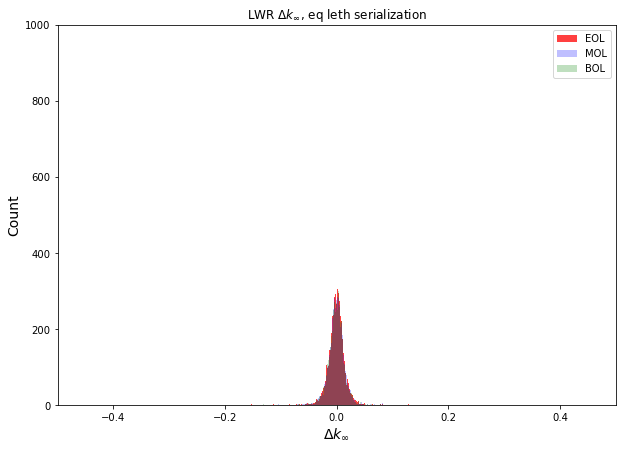

In [13]:
# Creating dataset
a = (y_predicted-y_test.T)
print(a.shape)
# Creating histogram
fig, ax = plt.subplots(figsize =(10, 7))
ax.hist(a[:,2],bins=500,alpha=0.75,label="EOL",color='r')
ax.hist(a[:,1],bins=500,alpha=0.25,label="MOL",color='b')
ax.hist(a[:,0],bins=500,alpha=0.25,label="BOL",color='g')
plt.xlabel("$Δk_{\infty}$", size=14)
plt.ylabel("Count", size=14)
plt.title("LWR $Δk_{\infty}$, eq leth serialization")
plt.legend(loc='upper right')
plt.xlim([-0.5,0.5])
plt.ylim([0,1000])

plt.savefig("PICS/SFR_deltaK_eqleth.png",bbox_inches ="tight",
            pad_inches = 1,
            transparent = False,
            facecolor ="w",
            edgecolor ='w',
            orientation ='landscape')
# Show plot
plt.show()


In [14]:
print(np.std(X_test[:,0]))
print(np.std(a[:,0]))
print(np.std(X_test[:,1]))
print(np.std(a[:,1]))
print(np.std(X_test[:,2]))
print(np.std(a[:,2]))

0.16186506663871794
0.020320436379274578
0.16571913677010885
0.02063347075552276
0.16685606944661246
0.021022517965701835


In [15]:
print(y_predicted[:,0])
print(y_predicted.shape)
print(y_test.shape)


[1.9311227 1.953152  1.9383469 ... 1.9250858 1.8715037 1.9177428]
(9999, 3)
(3, 9999)


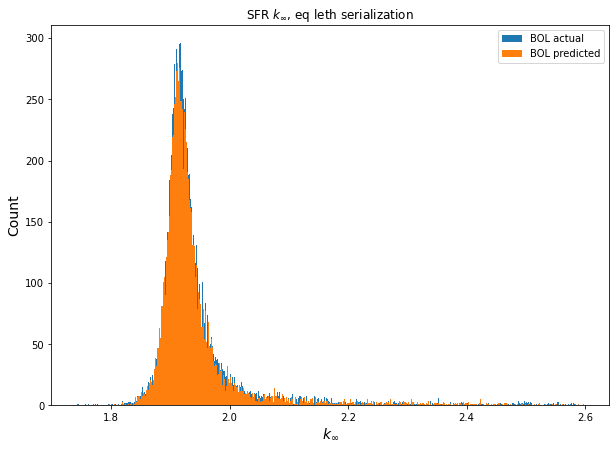

In [16]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib import colors
from matplotlib.ticker import PercentFormatter
 

n_bins = 500
 

# Creating histogram
fig, axs = plt.subplots(figsize =(10, 7))
 
axs.hist(y_test.T[:,0], bins = n_bins,label="BOL actual")
axs.hist(y_predicted[:,0], bins = n_bins,label="BOL predicted")


plt.xlabel("$k_{\infty}$", size=14)
plt.ylabel("Count", size=14)
plt.legend(loc='upper right')

plt.title("SFR $k_{\infty}$, eq leth serialization")
plt.savefig("PICS/kinfPredDist_eqleth.png",bbox_inches ="tight",
            pad_inches = 1,
            transparent = False,
            facecolor ="w",
            edgecolor ='w',
            orientation ='landscape')

plt.show()
# Show plot

